# Ungraded Lab: Keras custom callbacks
A custom callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference. Towards the end of this guide, there will be demos of creating a couple of simple callback applications to get you started on your custom callback.

## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.1.0


In [2]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
    return model

Then, load the MNIST data for training and testing from Keras datasets API:

In [3]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

11493376/11490434 [==============================] - 0s 0us/step


Now, define a simple custom callback to track the start and end of every batch of data. During those calls, it prints the index of the current batch.

In [4]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

Providing a callback to model methods such as `tf.keras.Model.fit()` ensures the methods are called at those stages:

In [5]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training: batch 0 begins at 13:06:01.381520
Training: batch 0 ends at 13:06:01.646803
Training: batch 1 begins at 13:06:01.647126
Training: batch 1 ends at 13:06:01.648700
Training: batch 2 begins at 13:06:01.648909
Training: batch 2 ends at 13:06:01.649866
Training: batch 3 begins at 13:06:01.650044
Training: batch 3 ends at 13:06:01.651069
Training: batch 4 begins at 13:06:01.651266
Training: batch 4 ends at 13:06:01.652296


## An overview of callback methods


### Common methods for training/testing/predicting
For training, testing, and predicting, following methods are provided to be overridden.
#### `on_(train|test|predict)_begin(self, logs=None)`
Called at the beginning of `fit`/`evaluate`/`predict`.
#### `on_(train|test|predict)_end(self, logs=None)`
Called at the end of `fit`/`evaluate`/`predict`.
#### `on_(train|test|predict)_batch_begin(self, batch, logs=None)`
Called right before processing a batch during training/testing/predicting. Within this method, `logs` is a dict with `batch` and `size` available keys, representing the current batch number and the size of the batch.
#### `on_(train|test|predict)_batch_end(self, batch, logs=None)`
Called at the end of training/testing/predicting a batch. Within this method, `logs` is a dict containing the stateful metrics result.

### Training specific methods
In addition, for training, following are provided.
#### `on_epoch_begin(self, epoch, logs=None)`
Called at the beginning of an epoch during training.
#### `on_epoch_end(self, epoch, logs=None)`
Called at the end of an epoch during training.


### Usage of `logs` dict
The `logs` dict contains the loss value, and all the metrics at the end of a batch or epoch. Example includes the loss and mean absolute error.

In [6]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs: 
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)

model = get_model()
_ = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=3,
          verbose=0,
          callbacks=[callback])

Epoch: 0, Val/Train loss ratio: 2.65
Epoch: 1, Val/Train loss ratio: 1.81
Epoch: 2, Val/Train loss ratio: 1.42


In [7]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])

Epoch: 0, Val/Train loss ratio: 3.40
Stopping training...


Similarly, one can provide callbacks in `evaluate()` calls.

## Custom callback to Visualize predictions

In [8]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [9]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

In [10]:
GIF_PATH = './animation.gif'

In [11]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []
        self.display_freq = display_freq
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

In [12]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

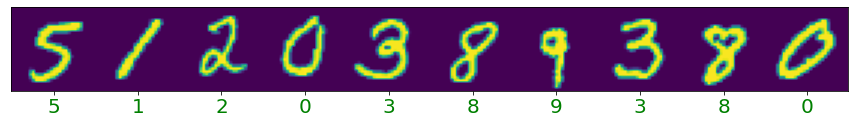

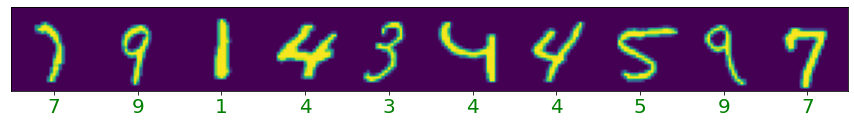

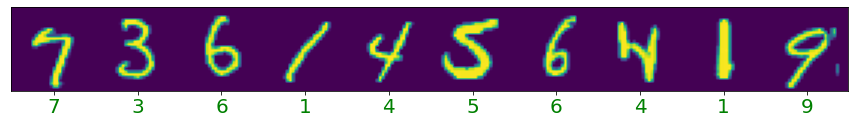

In [13]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

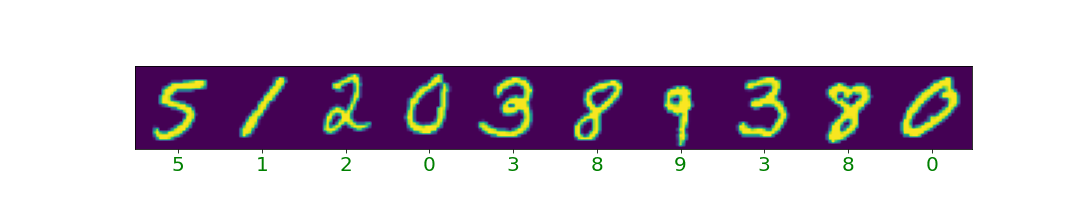

In [14]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE) 